In [1]:
# !pip install git+https://github.com/openai/CLIP.git
# !pip install imbalanced-learn

# commented out pips
# replaced the data_path and base_image_path, tan_directory, df1, df2, final_df.to_csv
# Please make sure to only add this file, and not the other green ones. I don't want to brake stuff


In [2]:
import pandas as pd
import torch
import clip
from PIL import Image, UnidentifiedImageError 
import os
from tqdm import tqdm  
import efficientnet_pytorch as Efficinet

# Set paths
data_path = "data_NOH.csv"  # '/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv'
base_image_path = "" # '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the CSV
df = pd.read_csv(data_path)

print(clip.__file__)

# Load the CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to process a single image and text entry through CLIP
def process_image_and_text(image_path, text, model, preprocess):
    # Open image with error handling for corrupt files
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error opening image {image_path}: {e}. Skipping.")
        return None, None  # Return None to indicate failure

    # Process text
    text_tokens = clip.tokenize([text]).to(device)

    # Get embeddings
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

    return image_features.cpu().numpy(), text_features.cpu().numpy()

# Initialize the list to keep track of successfully processed image paths
processed_image_paths = []

# Iterate over the dataframe and compute embeddings with progress bar
image_embeddings = []
text_embeddings = []

# Wrap the iteration in tqdm for progress tracking
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows", unit="row"):
    img_path = os.path.join(base_image_path, row['image_path'].replace('\\', '/'))
    diagnosis_text = row['Surgery diagnosis']

    if os.path.exists(img_path):
        # Process image and text
        img_embed, txt_embed = process_image_and_text(img_path, diagnosis_text, model, preprocess)
        
        if img_embed is not None and txt_embed is not None:
            image_embeddings.append(img_embed)
            text_embeddings.append(txt_embed)
            # Append the successful image path to the list
            processed_image_paths.append(row['image_path'])
    else:
        print(f"Image {img_path} does not exist. Skipping.")

# Convert embeddings to arrays and save for later use
if image_embeddings:
    image_embeddings = torch.cat([torch.tensor(x) for x in image_embeddings], dim=0)
    torch.save(image_embeddings, 'image_embeddings.pt')

if text_embeddings:
    text_embeddings = torch.cat([torch.tensor(x) for x in text_embeddings], dim=0)
    torch.save(text_embeddings, 'text_embeddings.pt')

print("Embeddings saved!")

ModuleNotFoundError: No module named 'efficientnet_pytorch'

In [ ]:
import numpy as np
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Check the shape of the image embeddings
print(image_embeddings.shape)
# Check the number of image embeddings generated
print(len(image_embeddings))

In [ ]:
import torch

# Load the embeddings
image_embeddings = torch.load('image_embeddings.pt')
text_embeddings = torch.load('text_embeddings.pt')
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    image_embeddings, labels, test_size=0.25, random_state=42, stratify=labels)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Train a logistic regression model with class weight and regularization
clf = LogisticRegression(class_weight='balanced', C=0.8)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate with ROC-AUC score
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", auc_score)


# Merge Shit

In [ ]:
import os

# Define the path to the TAN directory
tan_directory = "TAN" # '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN'  # Update this path to your TAN folder

# Iterate through all files in the directory
for filename in os.listdir(tan_directory):
    if filename.startswith("TAN"):  # Check if the filename starts with "TAN"
        # Remove the "TAN" prefix
        new_filename = filename.replace("TAN", "", 1)  # Remove "TAN" only once
        new_filename = new_filename.lstrip("\\")  # Remove any leading backslashes if necessary
        
        # Create full paths for renaming
        old_file = os.path.join(tan_directory, filename)
        new_file = os.path.join(tan_directory, new_filename)
        
        # Rename the file
        os.rename(old_file, new_file)

print("Files renamed successfully!")


In [ ]:
import pandas as pd

# Load the first CSV file
df1 =  pd.read_csv('data_NOH.csv') # pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv')

# Load the second CSV file
df2 = pd.read_csv('data_TAN.csv') # pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_TAN_V2.csv')

# Select relevant columns from df1
columns_df1 = [
    'Patient #',
    'Surgery diagnosis in number',
    'image_path',  # Keep the image_path from df1
    'Surgery diagnosis'
]

# Select relevant columns from df2
columns_df2 = [
    'Patient #',
    'Surgery diagnosis in number',  # Include relevant columns from df2
    'image_path',                    # Keep the image_path from df2
    'Surgery diagnosis'
]

# Create DataFrames with only the selected columns
df1_selected = df1[columns_df1]
df2_selected = df2[columns_df2]

# Get the maximum patient number from df1
max_patient_number = df1_selected['Patient #'].max()

# Update patient numbers in df2 by adding max_patient_number
df2_selected['Patient #'] = df2_selected['Patient #'] + max_patient_number

# Concatenate the two DataFrames vertically
final_df = pd.concat([df1_selected, df2_selected], ignore_index=True)

# Save the combined DataFrame to a new CSV file
# final_df.to_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv', index=False)
final_df.to_csv('Thyroid_Cancer_TAN&NOH_file.csv', index=False)

print("Super CSV file with adjusted Patient # has been created!")


In [ ]:
import pandas as pd

# Load the first CSV file
df1 = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv')

# Load the second CSV file
df2 = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_TAN_V2.csv')

# Select relevant columns from df1
columns_df1 = [
    'Patient #',
    'Surgery diagnosis in number',
    'image_path'  # Keep the image_path from df1
]

# Select relevant columns from df2
columns_df2 = [
    'Patient #',
    'Surgery diagnosis in number',  # Include relevant columns from df2
    'image_path'                    # Keep the image_path from df2
]

# Create DataFrames with only the selected columns
df1_selected = df1[columns_df1]
df2_selected = df2[columns_df2]

# Get the maximum patient number from df1
max_patient_number = df1_selected['Patient #'].max()

# Update patient numbers in df2 by adding max_patient_number
df2_selected['Patient #'] = df2_selected['Patient #'] + max_patient_number

# Adjust image_path in df2_selected to format it correctly
df2_selected['image_path'] = df2_selected['image_path'].str.replace(r'TAN/', '', regex=True)  # Remove 'TAN/' prefix

# Extract the numeric part; fill NaN values with empty strings to avoid TypeError
df2_selected['image_number'] = df2_selected['image_path'].str.extract(r'(\d+)')  # Extract the numeric part

# Construct the new image_path without duplicating 'TAN'
df2_selected['image_path'] = 'TAN\\' + df2_selected['image_number'].fillna('Unknown') + '\\' + df2_selected['image_path'].str.replace(r'TAN\d*\\', '', regex=True)

# Drop the image_number column
df2_selected = df2_selected.drop(columns=['image_number'])

# Concatenate the two DataFrames vertically
final_df = pd.concat([df1_selected, df2_selected], ignore_index=True)

# Save the combined DataFrame to a new CSV file
final_df.to_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv', index=False)

print("Super CSV file with adjusted Patient # and image_path has been created!")


In [ ]:
import pandas as pd
import torch
import clip
from PIL import Image, UnidentifiedImageError 
import os
from tqdm import tqdm  

# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'  # Update to your super CSV file
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'  # Adjust based on where your images are located

# Load the CSV
df = pd.read_csv(data_path)

# Load the CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to process a single image and text entry through CLIP
def process_image_and_text(image_path, text, model, preprocess):
    # Open image with error handling for corrupt files
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error opening image {image_path}: {e}. Skipping.")
        return None, None  # Return None to indicate failure

    # Process text
    text_tokens = clip.tokenize([text]).to(device)

    # Get embeddings
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

    return image_features.cpu().numpy(), text_features.cpu().numpy()

# Initialize the list to keep track of successfully processed image paths
processed_image_paths = []

# Iterate over the dataframe and compute embeddings with progress bar
image_embeddings = []
text_embeddings = []

# Wrap the iteration in tqdm for progress tracking
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows", unit="row"):
    # Construct the full image path
    img_path = os.path.join(base_image_path, row['image_path'].replace('\\', '/'))
    diagnosis_text = str(row['Surgery diagnosis in number'])  # Use surgery diagnosis in number as text

    if os.path.exists(img_path):
        # Process image and text
        img_embed, txt_embed = process_image_and_text(img_path, diagnosis_text, model, preprocess)
        
        if img_embed is not None and txt_embed is not None:
            image_embeddings.append(img_embed)
            text_embeddings.append(txt_embed)
            # Append the successful image path to the list
            processed_image_paths.append(row['image_path'])
    else:
        print(f"Image {img_path} does not exist. Skipping.")

# Convert embeddings to arrays and save for later use
if image_embeddings:
    image_embeddings = torch.cat([torch.tensor(x) for x in image_embeddings], dim=0)
    torch.save(image_embeddings, 'image_embeddings.pt')

if text_embeddings:
    text_embeddings = torch.cat([torch.tensor(x) for x in text_embeddings], dim=0)
    torch.save(text_embeddings, 'text_embeddings.pt')

print("Embeddings saved!")


In [ ]:
import numpy as np
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Check the shape of the image embeddings
print(image_embeddings.shape)
# Check the number of image embeddings generated
print(len(image_embeddings))

In [ ]:
import torch

# Load the embeddings
image_embeddings = torch.load('image_embeddings.pt')
text_embeddings = torch.load('text_embeddings.pt')
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]

In [ ]:
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming you have your image_embeddings and labels defined
# Filter out rows where labels are NaN
valid_indices = ~np.isnan(labels)
image_embeddings_filtered = image_embeddings[valid_indices]
labels_filtered = labels[valid_indices]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    image_embeddings_filtered, labels_filtered, test_size=0.25, random_state=42, stratify=labels_filtered)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a logistic regression model
clf = LogisticRegression(class_weight='balanced', C=0.8)
clf.fit(X_train_resampled, y_train_resampled)

# Save the model
dump(clf, 'logistic_regression_model.joblib')  # Using joblib
# or
# with open('logistic_regression_model.pkl', 'wb') as file:  # Using pickle
#     pickle.dump(clf, file)

# Load the model
clf_loaded = load('logistic_regression_model.joblib')  # Using joblib
# or
# with open('logistic_regression_model.pkl', 'rb') as file:  # Using pickle
#     clf_loaded = pickle.load(file)

# Make predictions with the loaded model
y_pred = clf_loaded.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate with ROC-AUC score
auc_score = roc_auc_score(y_test, clf_loaded.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", auc_score)


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm  # Import tqdm for progress bar
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Assuming RGB images
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 1)  # Binary classification (output one value)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Flatten the tensor
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match CNN input size
    transforms.ToTensor(),
])


# Simple CNN

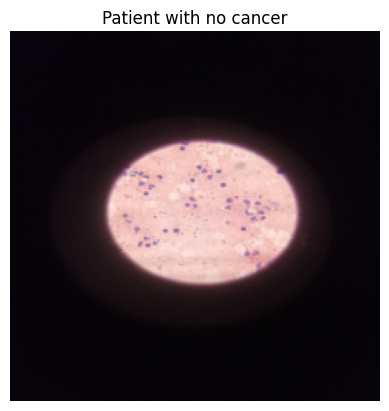

<Figure size 640x480 with 0 Axes>

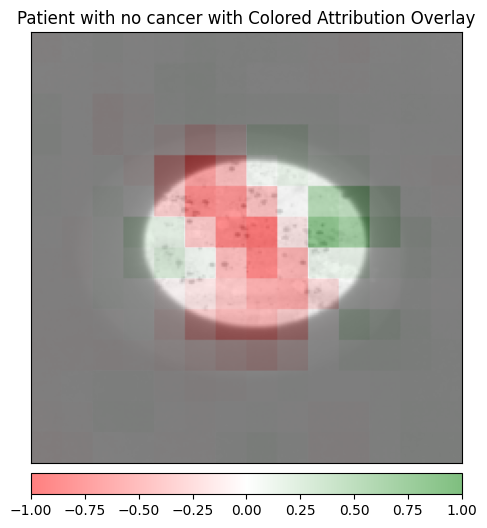

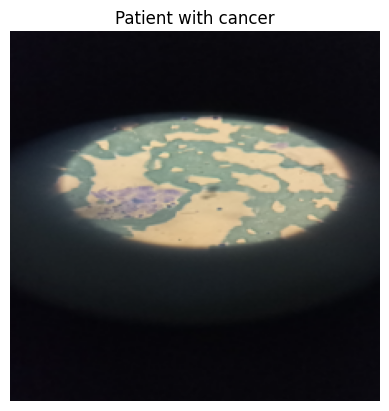

<Figure size 640x480 with 0 Axes>

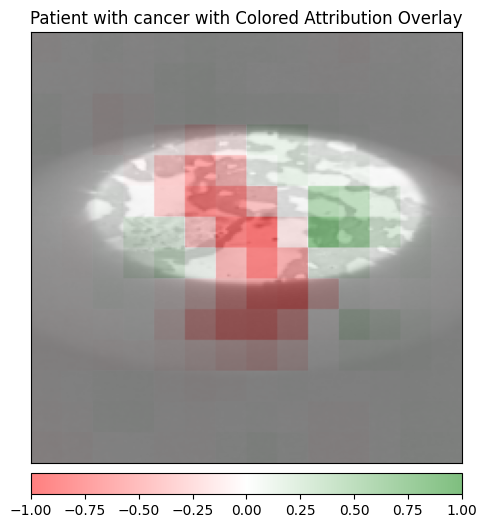

Epoch 1/200:   8%|▊         | 6/77 [00:58<11:34,  9.78s/batch, loss=0.659]


KeyboardInterrupt: 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm  # Import tqdm for progress bar

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pdb

from PIL import Image
from transformers import CLIPProcessor, CLIPModel

from plip import PLIP
import numpy as np

# Set paths
data_path = 'Thyroid_Cancer_TAN&NOH_file.csv' #'/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'
base_image_path = '' # '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the dataset using ImageFolder
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match CNN input size
    transforms.ToTensor(),
])

# Create your own Dataset class to load images and labels
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Surgery diagnosis in number']

        if self.transform:
            image = self.transform(image)

        return image, label

def displayHeatMap(img, label):
    output = model(test_img)
    pred_label_idx = output.argmax(dim=1).item()

    # Compute the attributions
    attributions_occ = occlusion.attribute(
        test_img,
        target=pred_label_idx,
        strides=(16, 16),  # Spatial dimensions only
        sliding_window_shapes=(32, 32),  # Spatial dimensions only
        baselines=0
    )
    plt.figure(1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(f'Patient with {"cancer" if label == 1 else "no cancer"}')
    plt.axis('off')
    plt.show()

    plt.figure(2)
    # Overlay the attribution on top of the original image with the chosen colormap
    _ = viz.visualize_image_attr(
        np.expand_dims(attributions_occ.squeeze().cpu().detach().numpy(), axis=-1),
        np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        method="blended_heat_map",
        sign="all",
        show_colorbar=True,
        title=f'Patient with {"cancer" if label == 1 else "no cancer"} with Colored Attribution Overlay',
        # fig_size=(8, 8),
        use_pyplot=True,
        alpha_overlay=0.5  # Control the transparency of the overlay (0 is fully transparent, 1 is fully opaque)
    )

# Load data and prepare for training
df = pd.read_csv(data_path)
df = df.dropna(subset=['Surgery diagnosis in number'])  # Drop rows with NaN labels

plip = PLIP('vinid/plip')

plip_model = CLIPModel.from_pretrained("vinid/plip")
plip_processor = CLIPProcessor.from_pretrained("vinid/plip")
plip_texts = np.unique(df['Surgery diagnosis']).tolist()

# Split the data
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Create datasets and loaders
train_dataset = CustomDataset(train_df, base_image_path, transform=transform)
test_dataset = CustomDataset(test_df, base_image_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()  # For binary classification

# Training loop with tqdm
num_epochs = 200
best_val_acc = 0.0  # To keep track of the best validation accuracy

# Heat map using captum
heat_map_data_iter = iter(test_loader)
heat_map_images, heat_map_labels = next(heat_map_data_iter)
test_img = heat_map_images[0]
test_label = heat_map_labels[0]

occlusion = Occlusion(model)

displayHeatMap( heat_map_images[0], heat_map_labels[0])
displayHeatMap( heat_map_images[2], heat_map_labels[2])


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs.squeeze()))
            correct_predictions += (predictions == labels).sum().item()

            # Update progress bar
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)  # Increment the progress bar

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader)
    train_acc = correct_predictions / len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float().to(device))

            val_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs.squeeze()))
            val_correct_predictions += (predictions == labels.float().to(device)).sum().item()

            val_labels.extend(labels.numpy())
            val_preds.extend(predictions.cpu().numpy())
            
            # add in plip guesses
            for image in images:
                plip_inputs = plip_processor(text=plip_texts, images=image, return_tensors="pt", padding=True)

                plip_outputs = plip_model(**plip_inputs)
                plip_logits_per_image = plip_outputs.logits_per_image  # this is the image-text similarity score
                plip_probs = plip_logits_per_image.softmax(dim=1) 
                plip_response = plip_texts[np.argmax(plip_probs.detach().numpy() )]
                print(plip_response)

    # Calculate average validation loss and accuracy
    val_loss /= len(test_loader)
    val_acc = val_correct_predictions / len(test_dataset)

    # Print metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Heat map using captum

    heat_map_data_iter = iter(test_loader)
    heat_map_images, heat_map_labels = next(heat_map_data_iter)
    test_img = heat_map_images[0]
    test_label = heat_map_labels[0]

    output = model(test_img)
    pred_label_idx = output.argmax(dim=1).item()

    occlusion = Occlusion(model)

    displayHeatMap( heat_map_images[0], heat_map_labels[0])
    displayHeatMap( heat_map_images[2], heat_map_labels[2])

    # Save the model if the validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'super_CNN_Model.pth')
        print("Model saved with best validation accuracy!")

# Final evaluation
model.load_state_dict(torch.load('super_CNN_Model.pth'))  # Load the best model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))  # Convert probabilities to binary predictions
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred))

# Evaluate with ROC-AUC score
auc_score = roc_auc_score(y_true, y_pred)
print("ROC-AUC Score:", auc_score)

print("Training completed!")
#100 ep - 325 mins, best val acc 88.18% #200 ep - 682 min, best val acc 88.41%

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the model and evaluate
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('super_CNN_Model.pth'))  # Load the best model
model.eval()  # Set to evaluation mode

# Example inference on a single image
def predict_image(image_path, model, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title('Input Image')
    plt.show()

    # Transform and add batch dimension
    image_transformed = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_transformed)
        probability = torch.sigmoid(output).item()  # Get the probability (confidence between 0-1)
        
        # Classify based on the probability threshold (0.5 by default)
        if probability >= 0.5:
            prediction = 'Cancer'
            confidence = probability
        else:
            prediction = 'Non-Cancer'
            confidence = 1 - probability  # Confidence for non-cancer is 1 - probability
            
    return prediction, confidence

# Use the prediction function
sample_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/001/IMG_20220623_134910.jpg'  # Replace with actual path
predicted_class, confidence = predict_image(sample_image_path, model, transform, device)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.4f}')


NameError: name 'SimpleCNN' is not defined

# Train the plip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm  # Import tqdm for progress bar

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pdb

from PIL import Image
from transformers import CLIPProcessor, CLIPModel

from plip import PLIP
import numpy as np

import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

# ---------------------------------------------------------------------------------------------------------------------

# Set paths
data_path = 'Thyroid_Cancer_TAN&NOH_file.csv' #'/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'
base_image_path = '' # '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# class CLIPBinaryClassifier(nn.Module):
#     def __init__(self, clip_model):
#         super(CLIPBinaryClassifier, self).__init__()
#         self.clip_model = clip_model
        
#         hidden_size = clip_model.text_model.config.hidden_size  
              
#         # Modify the final layer to produce 2 logits for binary classification
#         self.classifier = nn.Linear(hidden_size, 2)  # 2 output classes
        
#     def forward(self, input_ids, pixel_values):
#         # Get the outputs from the CLIP model
#         outputs = self.clip_model(input_ids=input_ids, pixel_values=pixel_values)
        
#         # Get the logits per image (for classification)
#         logits_per_image = outputs.logits_per_image
        
#         # Pass logits through the classifier to reduce the number of classes to 2
#         logits_per_image = self.classifier(logits_per_image)  # [batch_size, 2]
        
#         # Return the logits for both image and text
#         return logits_per_image, outputs.logits_per_text

# Load the pretrained CLIP model
model = CLIPModel.from_pretrained("vinid/plip")
# Wrap the model with the binary classifier
# model = CLIPBinaryClassifier(clip_model)
processor = CLIPProcessor.from_pretrained("vinid/plip")
 
class image_title_dataset():
    def __init__(self, dataframe, base_path):
        self.image_paths = [os.path.join(base_path, row['image_path'].replace('\\', '/')) for _, row in dataframe.iterrows()]
        # self.labels = [clip.tokenize('benign') if row['Surgery diagnosis in number'] == 0 else clip.tokenize('cancer') for _, row in dataframe.iterrows()]
        self.labels = [ row['Surgery diagnosis in number']  for _, row in dataframe.iterrows()]
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)), 
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and preprocess
        image = Image.open(self.image_paths[idx])
        image = self.preprocess(image)     
        label = self.labels[idx]
        
        return image, label

# Load data and prepare for training
df = pd.read_csv(data_path)
df = df.dropna(subset=['Surgery diagnosis in number'])  # Drop rows with NaN labels

# Split the data
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Create datasets and loaders
train_dataset = image_title_dataset(train_df, base_image_path)
test_dataset = image_title_dataset(test_df, base_image_path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# ---------------------------------------------------------------------------------------------------------------------

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# the text classes the model will be using
text = clip.tokenize(["benign", "cancer"]).to(device)

# Training loop -------------------------------------------------------------------------------------------------------

num_epochs = 1000
for epoch in range(num_epochs):

    print("Training")
    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        optimizer.zero_grad()
        
        images,labels = batch 
        images= images.to(device)
        labels= labels.to(device).long()

        # Forward pass
        output = model(text, pixel_values=images)

        logits_per_image = output.logits_per_image
        logits_per_text = output.logits_per_text
        
        # image_predictions = torch.argmax(logits_per_image, dim=1)

        # Compute loss
        total_loss = (loss_img(logits_per_image, labels))

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

# Validation loop -----------------------------------------------------------------------------------------------------

    print("Validation")
    num_correct = 0
    all_probs = []
    all_labels = []
    all_scores = []
    
    pbar = tqdm(test_loader, total=len(test_loader))
    for batch in pbar:
        with torch.no_grad():
            
            images,labels = batch 
            images= images.to(device)
            labels= labels.to(device).long()
            # Encode image and text
            # image_features = model.encode_image(image)
            # text_features = model.encode_text(text)
            
            # Calculate similarity scores between image and text
            output = model(text, images)
            logits_per_image = output.logits_per_image
            logits_per_text = output.logits_per_text
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            predicted_classes = probs.argmax(axis=1)
            num_correct = np.sum(predicted_classes == labels.numpy())
            
            all_probs.extend(predicted_classes)
            all_labels.extend(labels)
            all_scores.extend(probs[:, 1])

    print(classification_report(all_labels, all_probs))
    print(f"AUC: {roc_auc_score(all_labels, all_scores)}")
    print()
    
    torch.save(model.state_dict(), f'model{epoch}.pth')







GPU is not available.
Training


  0%|          | 0/77 [00:00<?, ?it/s]

# for running a saved model

In [6]:

# load in the model
model = CLIPModel.from_pretrained("vinid/plip")
model.load_state_dict(torch.load("model.pth"))

# test the model
print("Validation")
num_correct = 0
all_probs = []
all_labels = []
all_scores = []

pbar = tqdm(test_loader, total=len(test_loader))
for batch in pbar:
    with torch.no_grad():
        
        images,labels = batch 
        images= images.to(device)
        labels= labels.to(device).long()
        # Encode image and text
        # image_features = model.encode_image(image)
        # text_features = model.encode_text(text)
        
        # Calculate similarity scores between image and text
        output = model(text, images)
        logits_per_image = output.logits_per_image
        logits_per_text = output.logits_per_text
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        predicted_classes = probs.argmax(axis=1)
        num_correct = np.sum(predicted_classes == labels.numpy())
        
        all_probs.extend(predicted_classes)
        all_labels.extend(labels)
        all_scores.extend(probs[:, 1])

print(classification_report(all_labels, all_probs))
print(f"AUC: {roc_auc_score(all_labels, all_scores)}")
print()

C:\Users\pitstudent\AppData\Local\Temp\ipykernel_19760\3949199058.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


Validation


100%|██████████| 26/26 [00:58<00:00,  2.26s/it]

              precision    recall  f1-score   support

           0       0.92      0.34      0.50       365
           1       0.64      0.98      0.78       447

    accuracy                           0.69       812
   macro avg       0.78      0.66      0.64       812
weighted avg       0.77      0.69      0.65       812

AUC: 0.8053905795102817

